# Learnable Scalar Alpha Training for MKA

Train and evaluate learnable scalar α for layer merging.

## 1. Setup and Configuration

In [ ]:
import os
import sys
import subprocess
from huggingface_hub import login

# HuggingFace Authentication
HF_TOKEN = ""

if HF_TOKEN:
    login(token=HF_TOKEN)
    print("✓ Logged in to HuggingFace")

# Configuration
MODEL_PATH = "meta-llama/Meta-Llama-3-8B"
DATA_DIR = "./data"
NUM_LAYERS = 13  # Must match your baseline evaluation
OUTPUT_DIR_BASELINE = "./output_baseline"
OUTPUT_DIR_LEARNED = "./output_learned"

# Training hyperparameters
ALPHA_TRAINING_STEPS = 500
ALPHA_LEARNING_RATE = 1e-4
CALIBRATION_BATCH_SIZE = 4
CALIBRATION_SAMPLES = 100

print("=" * 60)
print("SCALAR ALPHA EXPERIMENT - CONFIGURATION")
print("=" * 60)
print(f"  Model: {MODEL_PATH}")
print(f"  Layers to merge: {NUM_LAYERS}")
print(f"  Training steps: {ALPHA_TRAINING_STEPS}")
print(f"  Learning rate: {ALPHA_LEARNING_RATE}")
print("=" * 60)

✓ Logged in to HuggingFace
SCALAR ALPHA EXPERIMENT - CONFIGURATION
  Model: meta-llama/Meta-Llama-3-8B
  Layers to merge: 13
  Training steps: 500
  Learning rate: 0.0001


## 2. Download MMLU Dataset (if needed)

In [2]:
# Download MMLU dataset (only need to run once)
import os
import subprocess

if not os.path.exists("./data"):
    print("📥 Downloading MMLU dataset...")
    # Clone the official MMLU repository
    !git clone https://github.com/hendrycks/test.git mmlu_download
    
    # Move the data folder
    !mv mmlu_download/data ./data
    
    # Clean up
    !rm -rf mmlu_download
    
    # Verify structure
    if os.path.exists("./data/dev") and os.path.exists("./data/test"):
        print("✅ MMLU dataset downloaded successfully!")
        dev_count = len([f for f in os.listdir("./data/dev") if f.endswith("_dev.csv")])
        test_count = len([f for f in os.listdir("./data/test") if f.endswith("_test.csv")])
        print(f"   Dev files: {dev_count}, Test files: {test_count}")
    else:
        print("⚠️ Download completed but structure looks wrong")
else:
    print("✅ Data directory already exists")

✅ Data directory already exists


## 3. Verify Data

In [3]:
# Check data directory
if os.path.exists(DATA_DIR):
    dev_files = os.listdir(os.path.join(DATA_DIR, "dev")) if os.path.exists(os.path.join(DATA_DIR, "dev")) else []
    test_files = os.listdir(os.path.join(DATA_DIR, "test")) if os.path.exists(os.path.join(DATA_DIR, "test")) else []
    print(f"✓ Data directory exists: {len(dev_files)} dev files, {len(test_files)} test files")
else:
    print(f"✗ Data directory not found: {DATA_DIR}")
    print("  Make sure MMLU data is in ./data/dev/ and ./data/test/")

✓ Data directory exists: 57 dev files, 57 test files


## 4. Train Learnable Alpha (saves model, ~30 min)

In [4]:
# Train learnable alpha and evaluate on MMLU
!python pipeline.py --model_path "meta-llama/Meta-Llama-3-8B" --num_layer 13 --data_dir "./data" --use_learnable_alpha --alpha_training_steps 500 --alpha_learning_rate 1e-4

Set pad_token to eos_token: <|end_of_text|>
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████████████| 4/4 [00:02<00:00,  1.69it/s]
Initial model configuration: LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "dtype": "bfloat16",
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.1",
  "use_cache": false,
  "vocab_size": 128256
}

Model metadata:
Number of layers: 32
Config num_hidden_layers: 32
Processing high_school_geography:

## 5. Load Fused Model

In [5]:
# Load the fused model with learned alphas
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

# Path to the saved fused model
MODEL_DIR = f"./output/Meta-Llama-3-8B/fused_{NUM_LAYERS}_layers/iteration/merged_weights"

print("Loading fused model with learned alphas...")
print(f"Model directory: {MODEL_DIR}")

# Check if model exists
if not os.path.exists(MODEL_DIR):
    print(f"❌ Model directory not found: {MODEL_DIR}")
    print("   Make sure training has completed successfully.")
else:
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_PATH,
        use_fast=True,
        trust_remote_code=True,
        padding_side="left"
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    # Load the fused model
    fused_model = AutoModelForCausalLM.from_pretrained(
        MODEL_DIR,
        trust_remote_code=True,
        device_map="auto",
        torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float32,
    )
    
    # Disable caching
    fused_model.config.use_cache = False
    
    print(f"✅ Model loaded successfully!")
    print(f"   Number of layers: {fused_model.config.num_hidden_layers}")
    print(f"   Model dtype: {fused_model.dtype}")

Loading fused model with learned alphas...
Model directory: ./output/Meta-Llama-3-8B/fused_13_layers/iteration/merged_weights


`torch_dtype` is deprecated! Use `dtype` instead!


✅ Model loaded successfully!
   Number of layers: 19
   Model dtype: torch.bfloat16


In [ ]:
# Safer loading: try CPU first to avoid device mismatch, then move to GPU or re-load with device_map
from transformers import AutoConfig

print("\n[Loader] Attempting CPU load to avoid device mismatches...")
fused_model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    trust_remote_code=True,
    device_map=None,  # load on CPU first
    torch_dtype=torch.float32,
)

# Optional: switch dtype if bf16 is available
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

if torch.cuda.is_available():
    print("[Loader] Moving model to GPU...")
    fused_model = fused_model.to("cuda" if not use_bf16 else torch.device("cuda"))
    if use_bf16:
        fused_model = fused_model.to(torch.bfloat16)
else:
    print("[Loader] CUDA not available; keeping model on CPU.")

fused_model.config.use_cache = False
print("[Loader] Load complete. Device of first param:", next(fused_model.parameters()).device)

In [ ]:
# Evaluate on MMLU
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import json

# MMLU evaluation function
choices = ["A", "B", "C", "D"]

def format_subject(subject):
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

def format_example(df, idx, include_answer=True):
    prompt = df.iloc[idx, 0]
    k = df.shape[1] - 2
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df.iloc[idx, j + 1])
    prompt += "\nAnswer:"
    if include_answer:
        prompt += " {}\n\n".format(df.iloc[idx, k + 1])
    return prompt

def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(
        format_subject(subject)
    )
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt

def _encode_for_model(prompt_text, tokenizer, model):
    enc = tokenizer(prompt_text, return_tensors="pt")
    # If model is sharded across devices (device_map), keep tensors on CPU
    if getattr(model, "hf_device_map", None) is not None:
        return enc
    # Otherwise move to the model's device
    dev = next(model.parameters()).device
    return {k: v.to(dev) for k, v in enc.items()}

@torch.no_grad()
def eval_subject(subject, model, tokenizer, dev_df, test_df, ntrain=5):
    cors = []
    total_loss = 0
    
    for i in tqdm(range(test_df.shape[0]), desc=f"Evaluating {subject}"):
        prompt_end = format_example(test_df, i, include_answer=False)
        train_prompt = gen_prompt(dev_df, subject, ntrain)
        prompt = train_prompt + prompt_end
        
        enc = _encode_for_model(prompt, tokenizer, model)
        input_ids = enc["input_ids"]
        labels = input_ids.clone()
        end_len = tokenizer(prompt_end, return_tensors="pt").input_ids.shape[1]
        labels[:, :-end_len] = -100
        
        outputs = model(input_ids=input_ids, labels=labels, use_cache=False)
        logits = outputs.logits[:, -1, :]
        loss = outputs.loss
        total_loss += loss.item()
        
        probs = torch.nn.functional.softmax(logits, dim=-1).detach().float().cpu().numpy()
        pred = choices[np.argmax(probs[:, [tokenizer(c).input_ids[-1] for c in choices]])]
        label = test_df.iloc[i, test_df.shape[1] - 1]
        
        cor = pred == label
        cors.append(cor)
    
    acc = np.mean(cors)
    avg_loss = total_loss / len(test_df)
    ppl = np.exp(avg_loss)
    
    return acc, ppl

# Run evaluation on all subjects
print("\n" + "="*60)
print("EVALUATING FUSED MODEL ON MMLU")
print("="*60)

fused_model.eval()

subjects = sorted([
    f.split("_test.csv")[0]
    for f in os.listdir(os.path.join(DATA_DIR, "test"))
    if "_test.csv" in f
])

all_accs = {}
all_ppls = {}

for subject in subjects:
    dev_df = pd.read_csv(
        os.path.join(DATA_DIR, "dev", subject + "_dev.csv"), header=None
    )[:5]  # Use 5 examples
    test_df = pd.read_csv(
        os.path.join(DATA_DIR, "test", subject + "_test.csv"), header=None
    )
    
    acc, ppl = eval_subject(subject, fused_model, tokenizer, dev_df, test_df, ntrain=5)
    
    all_accs[subject] = acc
    all_ppls[subject] = ppl
    
    print(f"Average accuracy {acc:.3f} - {subject}")
    print(f"Perplexity {ppl:.3f} - {subject}")

avg_acc = np.mean(list(all_accs.values()))
avg_ppl = np.mean(list(all_ppls.values()))

print("\n" + "="*60)
print("MMLU EVALUATION RESULTS (LEARNED ALPHA)")
print("="*60)
print(f"Average Accuracy:   {avg_acc:.4f}")
print(f"Average Perplexity: {avg_ppl:.4f}")
print("="*60)

# Save results
results = {
    "average_accuracy": float(avg_acc),
    "average_perplexity": float(avg_ppl),
    "per_subject_accuracy": {k: float(v) for k, v in all_accs.items()},
    "per_subject_perplexity": {k: float(v) for k, v in all_ppls.items()},
}

results_path = f"./output/Meta-Llama-3-8B/fused_{NUM_LAYERS}_layers/iteration/fusion_info/mmlu_results.json"
os.makedirs(os.path.dirname(results_path), exist_ok=True)
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {results_path}")


EVALUATING FUSED MODEL ON MMLU


Evaluating abstract_algebra: 100%|██████████| 100/100 [00:03<00:00, 26.47it/s]


Average accuracy 0.270 - abstract_algebra
Perplexity 48126.623 - abstract_algebra


Evaluating anatomy: 100%|██████████| 135/135 [00:04<00:00, 30.36it/s]


Average accuracy 0.681 - anatomy
Perplexity 27919.480 - anatomy


Evaluating astronomy: 100%|██████████| 152/152 [00:06<00:00, 22.25it/s]


Average accuracy 0.691 - astronomy
Perplexity 23785.286 - astronomy


Evaluating business_ethics: 100%|██████████| 100/100 [00:04<00:00, 22.21it/s]


Average accuracy 0.610 - business_ethics
Perplexity 19887.956 - business_ethics


Evaluating clinical_knowledge: 100%|██████████| 265/265 [00:09<00:00, 27.25it/s]


Average accuracy 0.717 - clinical_knowledge
Perplexity 30925.658 - clinical_knowledge


Evaluating college_biology: 100%|██████████| 144/144 [00:05<00:00, 25.57it/s]


Average accuracy 0.792 - college_biology
Perplexity 34268.266 - college_biology


Evaluating college_chemistry: 100%|██████████| 100/100 [00:04<00:00, 23.20it/s]


Average accuracy 0.460 - college_chemistry
Perplexity 44275.298 - college_chemistry


Evaluating college_computer_science: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


Average accuracy 0.520 - college_computer_science
Perplexity 39365.641 - college_computer_science


Evaluating college_mathematics: 100%|██████████| 100/100 [00:04<00:00, 21.79it/s]


Average accuracy 0.320 - college_mathematics
Perplexity 82838.259 - college_mathematics


Evaluating college_medicine: 100%|██████████| 173/173 [00:07<00:00, 24.47it/s]


Average accuracy 0.642 - college_medicine
Perplexity 25010.749 - college_medicine


Evaluating college_physics: 100%|██████████| 102/102 [00:04<00:00, 24.99it/s]


Average accuracy 0.490 - college_physics
Perplexity 62174.715 - college_physics


Evaluating computer_security: 100%|██████████| 100/100 [00:03<00:00, 28.90it/s]


Average accuracy 0.730 - computer_security
Perplexity 38993.669 - computer_security


Evaluating conceptual_physics: 100%|██████████| 235/235 [00:07<00:00, 31.42it/s]


Average accuracy 0.536 - conceptual_physics
Perplexity 36056.201 - conceptual_physics


Evaluating econometrics: 100%|██████████| 114/114 [00:05<00:00, 20.97it/s]


Average accuracy 0.447 - econometrics
Perplexity 34919.073 - econometrics


Evaluating electrical_engineering: 100%|██████████| 145/145 [00:05<00:00, 26.06it/s]


Average accuracy 0.641 - electrical_engineering
Perplexity 63365.057 - electrical_engineering


Evaluating elementary_mathematics: 100%|██████████| 378/378 [00:16<00:00, 23.10it/s]


Average accuracy 0.360 - elementary_mathematics
Perplexity 120050.635 - elementary_mathematics


Evaluating formal_logic: 100%|██████████| 126/126 [00:06<00:00, 20.94it/s]


Average accuracy 0.484 - formal_logic
Perplexity 34187.616 - formal_logic


Evaluating global_facts: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Average accuracy 0.330 - global_facts
Perplexity 13464.987 - global_facts


Evaluating high_school_biology: 100%|██████████| 310/310 [00:12<00:00, 24.27it/s]


Average accuracy 0.755 - high_school_biology
Perplexity 19517.802 - high_school_biology


Evaluating high_school_chemistry: 100%|██████████| 203/203 [00:08<00:00, 24.85it/s]


Average accuracy 0.512 - high_school_chemistry
Perplexity 27712.056 - high_school_chemistry


Evaluating high_school_computer_science: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Average accuracy 0.680 - high_school_computer_science
Perplexity 40894.771 - high_school_computer_science


Evaluating high_school_european_history: 100%|██████████| 165/165 [00:32<00:00,  5.02it/s]


Average accuracy 0.752 - high_school_european_history
Perplexity 9785.595 - high_school_european_history


Evaluating high_school_geography: 100%|██████████| 198/198 [00:07<00:00, 28.28it/s]


Average accuracy 0.854 - high_school_geography
Perplexity 22757.649 - high_school_geography


Evaluating high_school_government_and_politics: 100%|██████████| 193/193 [00:07<00:00, 25.39it/s]


Average accuracy 0.891 - high_school_government_and_politics
Perplexity 12137.234 - high_school_government_and_politics


Evaluating high_school_macroeconomics: 100%|██████████| 390/390 [00:13<00:00, 28.86it/s]


Average accuracy 0.638 - high_school_macroeconomics
Perplexity 14082.256 - high_school_macroeconomics


Evaluating high_school_mathematics: 100%|██████████| 270/270 [00:11<00:00, 23.19it/s]


Average accuracy 0.326 - high_school_mathematics
Perplexity 113330.233 - high_school_mathematics


Evaluating high_school_microeconomics: 100%|██████████| 238/238 [00:08<00:00, 27.18it/s]


Average accuracy 0.710 - high_school_microeconomics
Perplexity 14143.299 - high_school_microeconomics


Evaluating high_school_physics: 100%|██████████| 151/151 [00:06<00:00, 22.56it/s]


Average accuracy 0.424 - high_school_physics
Perplexity 23371.866 - high_school_physics


Evaluating high_school_psychology: 100%|██████████| 545/545 [00:21<00:00, 25.02it/s]


Average accuracy 0.850 - high_school_psychology
Perplexity 23435.768 - high_school_psychology


Evaluating high_school_statistics: 100%|██████████| 216/216 [00:12<00:00, 17.58it/s]


Average accuracy 0.565 - high_school_statistics
Perplexity 16413.233 - high_school_statistics


Evaluating high_school_us_history: 100%|██████████| 204/204 [00:30<00:00,  6.60it/s]


Average accuracy 0.814 - high_school_us_history
Perplexity 12019.515 - high_school_us_history


Evaluating high_school_world_history: 100%|██████████| 237/237 [00:23<00:00, 10.29it/s]


Average accuracy 0.814 - high_school_world_history
Perplexity 13740.413 - high_school_world_history


Evaluating human_aging: 100%|██████████| 223/223 [00:07<00:00, 31.15it/s]


Average accuracy 0.695 - human_aging
Perplexity 24886.731 - human_aging


Evaluating human_sexuality: 100%|██████████| 131/131 [00:04<00:00, 30.60it/s]


Average accuracy 0.771 - human_sexuality
Perplexity 23389.368 - human_sexuality


Evaluating international_law: 100%|██████████| 121/121 [00:05<00:00, 21.05it/s]


Average accuracy 0.843 - international_law
Perplexity 18782.917 - international_law


Evaluating jurisprudence: 100%|██████████| 108/108 [00:04<00:00, 26.82it/s]


Average accuracy 0.722 - jurisprudence
Perplexity 20258.437 - jurisprudence


Evaluating logical_fallacies: 100%|██████████| 163/163 [00:06<00:00, 26.25it/s]


Average accuracy 0.755 - logical_fallacies
Perplexity 13587.333 - logical_fallacies


Evaluating machine_learning: 100%|██████████| 112/112 [00:05<00:00, 19.91it/s]


Average accuracy 0.420 - machine_learning
Perplexity 28464.536 - machine_learning


Evaluating management: 100%|██████████| 103/103 [00:03<00:00, 32.11it/s]


Average accuracy 0.845 - management
Perplexity 25795.546 - management


Evaluating marketing: 100%|██████████| 234/234 [00:08<00:00, 27.46it/s]


Average accuracy 0.859 - marketing
Perplexity 24576.372 - marketing


Evaluating medical_genetics: 100%|██████████| 100/100 [00:03<00:00, 30.73it/s]


Average accuracy 0.800 - medical_genetics
Perplexity 26478.110 - medical_genetics


Evaluating miscellaneous: 100%|██████████| 783/783 [00:24<00:00, 31.51it/s]


Average accuracy 0.802 - miscellaneous
Perplexity 22632.478 - miscellaneous


Evaluating moral_disputes: 100%|██████████| 346/346 [00:13<00:00, 25.29it/s]


Average accuracy 0.691 - moral_disputes
Perplexity 11895.340 - moral_disputes


Evaluating moral_scenarios: 100%|██████████| 895/895 [00:44<00:00, 19.99it/s]


Average accuracy 0.292 - moral_scenarios
Perplexity 7998.556 - moral_scenarios


Evaluating nutrition: 100%|██████████| 306/306 [00:14<00:00, 21.28it/s]


Average accuracy 0.739 - nutrition
Perplexity 26852.128 - nutrition


Evaluating philosophy: 100%|██████████| 311/311 [00:10<00:00, 30.71it/s]


Average accuracy 0.730 - philosophy
Perplexity 14465.269 - philosophy


Evaluating prehistory: 100%|██████████| 324/324 [00:13<00:00, 24.78it/s]


Average accuracy 0.728 - prehistory
Perplexity 18876.720 - prehistory


Evaluating professional_accounting: 100%|██████████| 282/282 [00:13<00:00, 20.20it/s]


Average accuracy 0.433 - professional_accounting
Perplexity 25466.951 - professional_accounting


Evaluating professional_law: 100%|██████████| 1534/1534 [02:53<00:00,  8.84it/s]


Average accuracy 0.446 - professional_law
Perplexity 6833.999 - professional_law


Evaluating professional_medicine: 100%|██████████| 272/272 [00:21<00:00, 12.60it/s]


Average accuracy 0.699 - professional_medicine
Perplexity 20649.937 - professional_medicine


Evaluating professional_psychology: 100%|██████████| 612/612 [00:27<00:00, 22.01it/s]


Average accuracy 0.709 - professional_psychology
Perplexity 16911.632 - professional_psychology


Evaluating public_relations: 100%|██████████| 110/110 [00:04<00:00, 27.26it/s]


Average accuracy 0.645 - public_relations
Perplexity 18401.396 - public_relations


Evaluating security_studies: 100%|██████████| 245/245 [00:20<00:00, 12.21it/s]


Average accuracy 0.755 - security_studies
Perplexity 12700.354 - security_studies


Evaluating sociology: 100%|██████████| 201/201 [00:07<00:00, 26.26it/s]


Average accuracy 0.866 - sociology
Perplexity 17247.698 - sociology


Evaluating us_foreign_policy: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Average accuracy 0.840 - us_foreign_policy
Perplexity 13348.176 - us_foreign_policy


Evaluating virology: 100%|██████████| 166/166 [00:05<00:00, 30.44it/s]


Average accuracy 0.566 - virology
Perplexity 28908.366 - virology


Evaluating world_religions: 100%|██████████| 171/171 [00:05<00:00, 32.77it/s]

Average accuracy 0.830 - world_religions
Perplexity 38565.155 - world_religions

MMLU EVALUATION RESULTS (LEARNED ALPHA)
Average Accuracy:   0.6454
Average Perplexity: 28963.6906

✅ Results saved to: ./output/Meta-Llama-3-8B/fused_13_layers/iteration/fusion_info/mmlu_results.json


## 6. Evaluate on MMLU (~40-90 min)

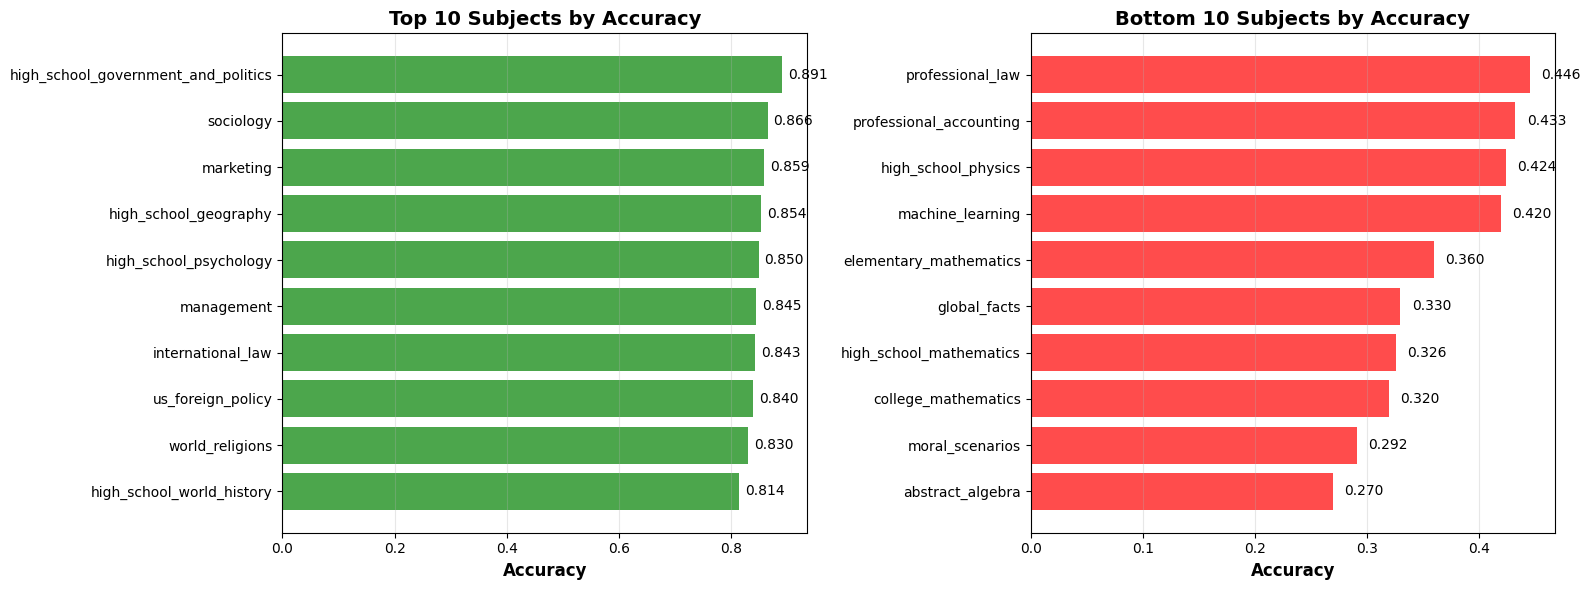


📊 Overall Average Accuracy: 0.6454


In [7]:
# Visualize top and bottom performing subjects
import matplotlib.pyplot as plt

# Sort subjects by accuracy
sorted_subjects = sorted(all_accs.items(), key=lambda x: x[1], reverse=True)

# Get top 10 and bottom 10
top_10 = sorted_subjects[:10]
bottom_10 = sorted_subjects[-10:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 subjects
subjects_top = [s[0] for s in top_10]
accs_top = [s[1] for s in top_10]

ax1.barh(range(len(subjects_top)), accs_top, color='green', alpha=0.7)
ax1.set_yticks(range(len(subjects_top)))
ax1.set_yticklabels(subjects_top, fontsize=10)
ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Subjects by Accuracy', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add accuracy values on bars
for i, acc in enumerate(accs_top):
    ax1.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=10)

# Bottom 10 subjects
subjects_bottom = [s[0] for s in bottom_10]
accs_bottom = [s[1] for s in bottom_10]

ax2.barh(range(len(subjects_bottom)), accs_bottom, color='red', alpha=0.7)
ax2.set_yticks(range(len(subjects_bottom)))
ax2.set_yticklabels(subjects_bottom, fontsize=10)
ax2.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Bottom 10 Subjects by Accuracy', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add accuracy values on bars
for i, acc in enumerate(accs_bottom):
    ax2.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Overall Average Accuracy: {avg_acc:.4f}")

## 7. Visualize Top/Bottom Subjects

LEARNED ALPHA STATISTICS
  Number of layers: 1
  Mean α: 0.4894
  Std α:  0.0000
  Min α:  0.4894
  Max α:  0.4894


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


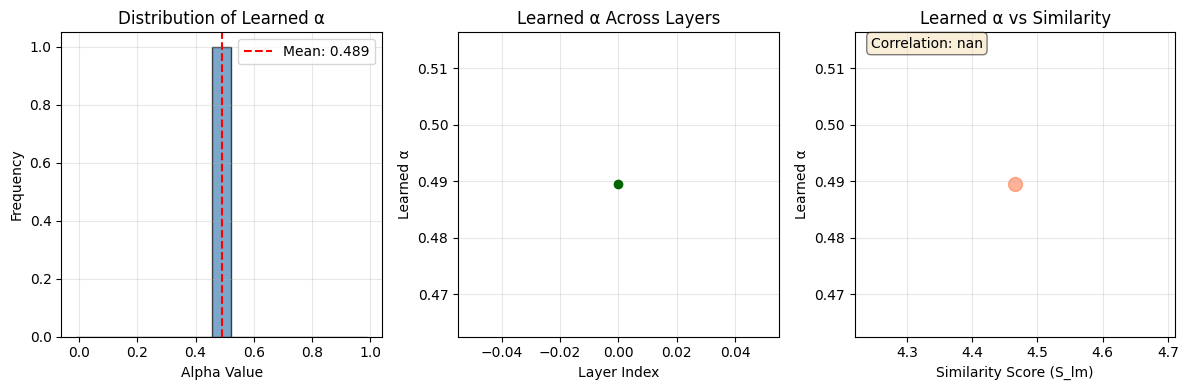


✓ Analysis complete! Check the plots above.


In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load learned alphas
learned_alphas_path = "./output/Meta-Llama-3-8B/fused_13_layers/iteration/merged_weights/learned_alphas.json"

if os.path.exists(learned_alphas_path):
    with open(learned_alphas_path, 'r') as f:
        data = json.load(f)
    
    learned_alphas = data.get('learned_alphas', [])
    similarity_scores = data.get('similarity_scores', [])
    
    print("=" * 60)
    print("LEARNED ALPHA STATISTICS")
    print("=" * 60)
    print(f"  Number of layers: {len(learned_alphas)}")
    print(f"  Mean α: {np.mean(learned_alphas):.4f}")
    print(f"  Std α:  {np.std(learned_alphas):.4f}")
    print(f"  Min α:  {np.min(learned_alphas):.4f}")
    print(f"  Max α:  {np.max(learned_alphas):.4f}")
    print("=" * 60)
    
    # Visualize alpha distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(learned_alphas, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
    plt.axvline(np.mean(learned_alphas), color='r', linestyle='--', label=f'Mean: {np.mean(learned_alphas):.3f}')
    plt.xlabel('Alpha Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Learned α')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Alpha vs layer index
    plt.subplot(1, 3, 2)
    plt.plot(range(len(learned_alphas)), learned_alphas, marker='o', linestyle='-', color='darkgreen')
    plt.xlabel('Layer Index')
    plt.ylabel('Learned α')
    plt.title('Learned α Across Layers')
    plt.grid(alpha=0.3)
    
    # Alpha vs Similarity
    if similarity_scores and len(similarity_scores) == len(learned_alphas):
        plt.subplot(1, 3, 3)
        plt.scatter(similarity_scores, learned_alphas, alpha=0.6, s=100, color='coral')
        plt.xlabel('Similarity Score (S_lm)')
        plt.ylabel('Learned α')
        plt.title('Learned α vs Similarity')
        corr = np.corrcoef(similarity_scores, learned_alphas)[0, 1]
        plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Analysis complete! Check the plots above.")
else:
    print(f"✗ Learned alphas not found: {learned_alphas_path}")
    print("  Training may still be running.")

## 8. Analyze Learned Alpha Values